In [1]:
from PC import PC
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [2]:
def getEdges(dictGraph):
    edges = []
    for node1, addjacents in dictGraph.items():
        for node2 in addjacents:
            edges.append((node1, node2))
    return edges

In [3]:
data = pd.read_csv('data/train.csv')
data.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked'], inplace=True)

data['Sex'] = data['Sex'].apply(lambda x: 1 if x=='male' else 0)

data.dropna(inplace=True)

In [4]:
def discretize(data, column, bins):
    data[column] = pd.cut(data[column], bins, labels=False)

# Age and Fare discretization
discretize(data, 'Age', 5)
discretize(data, 'Fare', 5)

In [5]:
data_train = data.sample(frac=0.8, random_state=200)
data_test = data.drop(data_train.index)

In [6]:
pc = PC(0.01, directional=True)

graph, separatingSets = pc.causalDiscovery(data_train)

Depth 0 completed
Depth 1 completed
Depth 2 completed
Depth 3 completed


In [7]:
print('Number of disconnections:', len(separatingSets))
for separatingSet in separatingSets:
    print(separatingSet[0], 'are sepated by', separatingSet[1])

Number of disconnections: 12
('Survived', 'Pclass') are sepated by {}
('PassengerId', 'Survived') are sepated by ('Survived',)
('PassengerId', 'Pclass') are sepated by ('SibSp',)
('PassengerId', 'Sex') are sepated by ('Sex',)
('PassengerId', 'Age') are sepated by ('Age',)
('PassengerId', 'Parch') are sepated by ('Fare',)
('Survived', 'Parch') are sepated by ('Fare',)
('Pclass', 'Fare') are sepated by ('Parch',)
('Sex', 'SibSp') are sepated by ('Pclass',)
('Sex', 'Parch') are sepated by ('Fare',)
('Age', 'Parch') are sepated by ('Survived',)
('SibSp', 'Parch') are sepated by ('PassengerId',)


In [8]:
graph.pop('PassengerId')
for key, value in graph.items():
    value.discard('PassengerId')

In [9]:
# Set all implications to <node>, none from it
def setEndogeneous(node):
    while len(graph[node]) != 0:
        addjacent = graph[node].pop()
        graph[addjacent].add(node)
        
def setExogeneous(node):
    for key, addjacents in graph.items():
        if node in addjacents:
            addjacents.remove(node)
            graph[node].add(key)

setExogeneous('Age')

setEndogeneous('Pclass')
setEndogeneous('Survived')

In [10]:
# Remove bidirectional edges
for key, value in graph.items():
    for addjacent in value:
        if key in graph[addjacent]:
            graph[addjacent].remove(key)

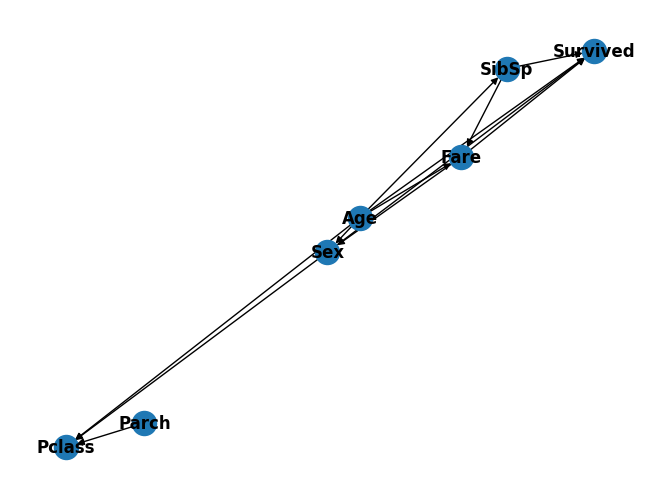

In [11]:
G = nx.DiGraph(getEdges(graph))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

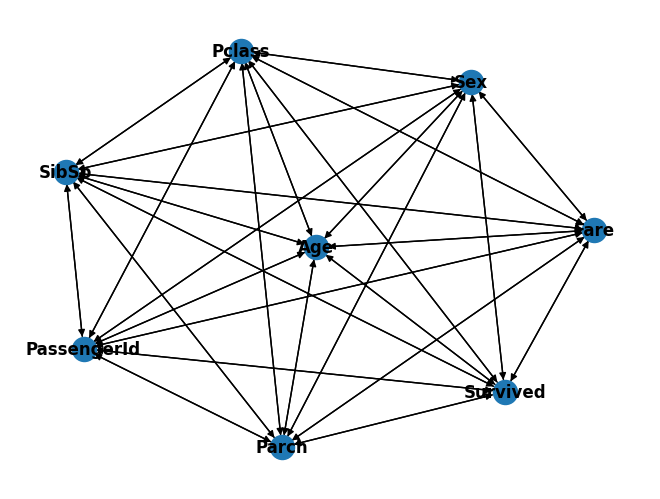

In [12]:
originalGraph = {column: set(data.columns.drop(column)) \
                            for column in data.columns}

G = nx.DiGraph(getEdges(originalGraph))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [13]:
X_features = list(graph.keys())
X_features.remove('Survived')

X_train = data_train[X_features]
X_test = data_test[X_features]

y_train = data_train['Survived']
y_test = data_test['Survived']

In [14]:
from pgmpy.models import BayesianNetwork

BN = BayesianNetwork()

BN.add_nodes_from(graph.keys())
for node, addjacent in graph.items():
    for addj in addjacent:
        BN.add_edge(node, addj)

In [15]:
BN.fit(data_train)

In [16]:
y_pred_BN = BN.predict(X_test)['Survived']

  0%|          | 0/68 [00:00<?, ?it/s]

In [17]:
from sklearn.metrics import f1_score

f1_BN = f1_score(y_test, y_pred_BN)

In [18]:
from pgmpy.models import BayesianNetwork

NB = BayesianNetwork([(feature, 'Survived') for feature in X_features])

In [19]:
NB.fit(data_train)

In [20]:
y_pred_NB = NB.predict(X_test)

  0%|          | 0/68 [00:00<?, ?it/s]

In [22]:
f1_NB = f1_score(y_test, y_pred_NB)
print("F1 Score:\nBayesian Network ->", f1_BN, "\nNaive Bayes ->", f1_NB)

F1 Score:
Bayesian Network -> 0.7572815533980584 
Naive Bayes -> 0.6588235294117648
